<a href="https://colab.research.google.com/github/raylaxmidas/CIVIL705/blob/master/SignalProcessingTempData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analysis of Temporary BNZ Sensors

The data used in this analysis was collected with MEL-x2 sensors. The documentation can be found here:
http://www.gcdataconcepts.com/GCDC_MEL_Data_Logger_User_Manual.pdf

##Signal Processing Tools

###Python Libraries

Importing relevant libraries:

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy import signal
import numpy as np
from IPython.display import clear_output

!pip install eqsig
import eqsig

###My Signal Processing Tools

####Reading CSVs

This function below reads in the CSV Files given the file name:

In [ ]:
#Reading in acceleration data from CSV File
def read(file_name):
    acc_table = pd.read_csv(file_name, header = 8)
    acc_table.columns = ['time','Ax','Ay','Az','rubbish']
    acc_table = acc_table.drop("rubbish", axis=1)
    return acc_table

####Visualization

This function below in a table of accelerations with the headers: time, Ax, Ay, Az and applies the following transformations:


1.   Divides the acceleration by the high gain counts of 13107.
2.   Detrends the data using a linear function. (Note as per meeting on 12-Jun Lucas has noted this function should use constant "teir" shift rather than a linear function)

Note the application of this function applied to each CSV as they read in, NOT the entire singal for memory optimsation.




In [ ]:
#Processes data adjusting for co-efficients
def process(acc_table):
    
    #Adjust for high gain "counts/g" to arrive at units g, see documentations for sensor pg 4.
    acc_table['Ax'] = acc_table['Ax'].div(13107)
    acc_table['Ay'] = acc_table['Ay'].div(13107)
    acc_table['Az'] = acc_table['Az'].div(13107)
    
    #Convert DF to arrays
    Ax = acc_table["Ax"].tolist()
    Ay = acc_table["Ay"].tolist()
    Az = acc_table["Az"].tolist()
    
    #Detrend arrays
    Ax = signal.detrend(Ax, axis=-1, type='linear', bp=0)
    Ay = signal.detrend(Ay, axis=-1, type='linear', bp=0)
    Az = signal.detrend(Az, axis=-1, type='linear', bp=0)
    
    #Replace DF data with detrended data.
    acc_table = acc_table.assign(Ax = Ax)
    acc_table = acc_table.assign(Ay = Ay)
    acc_table = acc_table.assign(Az = Az)
    
    return acc_table

This function below takes a table of acceleration with the headers time Ax, Ay, Az and plots the time against: Ax, Ay, Az - all on the same figure.


In [ ]:
#Plot acceleration vs. time
def drawXYZ(acc_table):  
    fig, (ax1,ax2,ax3) = plt.subplots(3, 1)
    
    fig.text(0.5, 0.04, 'Time (s)', ha='center', va='center')
    fig.tight_layout(pad=3.0)
    
    #X Acceleration
    acc_table.plot(x = 'time' , y='Ax', color='r', linewidth=0.25, ax = ax1, title = 'X Acceleration', figsize = (20,10))
    ax1.grid()
    
    #Y Acceleration
    acc_table.plot(x = 'time' , y='Ay', color='b', linewidth=0.25, ax = ax2, title = 'Y Acceleration', figsize = (20,10))
    ax2.grid()

    #Y Acceleration
    acc_table.plot(x = 'time' , y='Az', color='g', linewidth=0.25, ax = ax3, title = 'Z Acceleration', figsize = (20,10))
    ax3.grid()
    
    #Plot and Save
    plt.show
    fig.savefig('Time_Vs_XYZ_Acc.png', dpi=400)

This function below takes a table of time and the X accelerations of multiple channels (i.e. headers time, Ax0, Ax1, Ax2, Ax3) and plots them all on one graph. This is helpful for comparing sensors over a specific time frame visually.

In [ ]:
#Compares multiple Ax from different sensors
def compare_ax_chans(acc_table):
#Number of Columns and Rows for Subplots
    Tot = len(acc_table.columns)-1
    Cols = 1

    Rows = Tot // Cols 
    Rows += Tot % Cols

    Position = range(1,Tot + 1)

    # Create main figure
    fig = plt.figure(1, figsize=(10,30))

    #Setup colours
    color = iter(cm.rainbow(np.linspace(0,1,Tot)))

    for k in range(Tot):
        #Define x and y axis
        x = acc_table['time']            
        y = acc_table['Ax' + str(k)]     
    
        #Add every single subplot to the figure each loop, iterate through colours
        ax = fig.add_subplot(Rows,Cols,Position[k])
        c = next(color)
        plt.xlim(60, 140) #Window Size for Graph - Turn off Comment if Required!
        ax.plot(x,y, c=c)
        #annot_max(x,y)

    #Set up graph size and titles, save to drive
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    fig.text(0.5, 0.1, 'Time (s)', ha='center')
    fig.text(0.04, 0.5, 'Acceleration (s)', va='center', rotation='vertical')
    fig.savefig('Comparison_of_Sensors_Ax_ONLY.png', dpi=400)

This function below annotates the maximum acceleration and at what time this occurs on time vs acc plot.

In [ ]:
#Annotates the maximum value in a plot.
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

####Concatinating

This function below takes two accelerations table with headers: time, Ax, Ay, Az and joins them together. The time of the file being added is summed with the terminal time of the file being joined to.

In [ ]:
#Joins two acceleration tables
def join(a,b):
    last_time = a.time.iat[-1]
    b['time'] += last_time
    frames = [a,b]
    result = pd.concat(frames)  
    return result

####Time Lag Analysis

This function below takes two arrays of acceleration data along with their respective sampling rate and calculates the delay between the two by maximising the cross correlation between the two function. A plot of the correlation coefficient and the time delays is also shown.

In [ ]:
#Find time lay between two sets of data, y1 = data1, y2 = data2, sr = sample rate
def lag_finder(y1, y2, sr, name):
    n = len(y1)  
    corr = signal.correlate(y2, y1, mode='same') / np.sqrt(signal.correlate(y1, y1, mode='same')[int(n/2)] * signal.correlate(y2, y2, mode='same')[int(n/2)])
    
    #Calculation Delay
    delay_arr = np.linspace(-0.5*n/sr, 0.5*n/sr, n)
    delay = delay_arr[np.argmax(corr)]
    
    #Plot Correlation Graph
    plt.figure()
    plt.plot(delay_arr, corr)
    plt.title('Lag: ' + str(np.round(delay, 3))+ ' s ' + name)
    plt.xlabel('Lag')
    plt.ylabel('Correlation Coefficient')
    plt.savefig(name, dpi=400)
    plt.show()
    
    return delay

This function below takes an acceleration table with headers: time, Ax0, Ax1, Ax2, Ax3... (i.e. the time of one sensor and the x-accelerations of multiple senors and calculates the time delays of the all the accelerations Ax1, Ax2... Axn - compared to Ax0).

In [ ]:
#Outputs time delay for first column in acc_table compared to all other columns
def lag_table(acc_table, sr):
    y1 = master_table['Ax0'].to_numpy()
    l = len(acc_table.columns)-1
    lags = []
    
    for x in range(l-1):
        y2 = acc_table['Ax'+str(x+1)].to_numpy()
        lag = lag_finder(y1,y2,sr,'Ax'+str(x+1))    
        lags.append(lag)
    return lags

####Fourier transform

The following fuction takes an acceleration tables with  headers: time, Ax, Ay, Az and produces the fourier transformation of the Ax data.

In [ ]:
#Outputs the FDD of and acc_table
def FDD(df):
        #Convert Data Frame to Float
        df[0:] = df[0:].astype(float)
                    
        #Create an Signal object
        acc = df['Ay'].to_numpy()
        dt = df.iloc[1,0]
        asig = eqsig.AccSignal(acc, dt, label='name_of_record')
        #asig.butter_pass((0.2, 20))  # Band pass filter at 0.2 and 6Hz (default 4th order)

        #Produce Fourier Spectrum
        plt.figure()
        plt.plot(asig.fa_frequencies, abs(asig.fa_spectrum), c='r')
        plt.title('Fourier Spectrum')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Fourier Amplitude [m/s]')
        plt.savefig('Fourier_Spectrum.png', dpi=400, bbox_inches='tight')
        plt.show()
        
        #Close plots
        #plt.close('all')
        return


## The initial setup of the main program. 

Input the directory and analysis type being either:


1.   An analysis of a single senors X, Y, Z acceleration direction. For this analysis ensure all the accleration CSVs of a single senor are in the directory (i.e. DATA-01.CSV, DATA-02.CSV, DATA-03.CSV).
2.   An analysis of multiple sensors. For this analysis ensure all the acceleration CSVs (of the SAME time) of the sensors being compared are in the directory (i.e. DATA-01.CSV of Sensor 12, 25, 105, 152, 153, 164, 165, 167, 168, 171, 172, 174, 175, 178 etc - n.b. they will need to be renamed to something such as 12, 24, 105 instead of DATA-01.CSV, DATA-01.CSV).



In [ ]:
#Ask for analysis type 
analysis_type = int(input("[1] = Visualize X,Y,Z Channel,\n[2] = Compare Multiple Channels (Insert DATA-01 of all channels into temp folder), \nEnter Analysis Type: "))

#Determine directory for analysis
if analysis_type == 1:
  dir = str("/content/drive/My Drive/University/2020 - Part IV/Semester 1/CIVIL 705P/Python Development/BNZ Temp Data/BNZ Temp Data/"+input("Enter the channel number:"))
else:
  dir = "/content/drive/My Drive/University/2020 - Part IV/Semester 1/CIVIL 705P/Python Development/BNZ Temp Data/BNZ Temp Data/Compare" #Directory for unadjusted sensor data.
  dir2 = "/content/drive/My Drive/University/2020 - Part IV/Semester 1/CIVIL 705P/Python Development/BNZ Temp Data/BNZ Temp Data/Compare_LagAdjust" #Directory for adjusted sensor data

size = len(sorted(os.listdir(dir)))

#Print directory
print("The directory being analysed is:")
print(dir)

[1] = Visualize X,Y,Z Channel,
[2] = Compare Multiple Channels (Insert DATA-01 of all channels into temp folder), 
Enter Analysis Type: 2
The directory being analysed is:
/content/drive/My Drive/University/2020 - Part IV/Semester 1/CIVIL 705P/Python Development/BNZ Temp Data/BNZ Temp Data/Compare


## Analysis Type 1:
Carries out the following steps on chronological data from a single sensor:


1.   Reads in .CSV files
2.   Cleans .CSV with process()
3.   Connects times and accelerations from .CSVs and sitches them together.
4.   Produce Time Vs. X,Y,Z Acceleration Graph.
5.   Produce Fourier Transformation of Data.

In [ ]:
#Draw XYZ Plot for Single Senor
def analysis1(dir):
    switch = 0
    i = 0
    for file in sorted(os.listdir(dir)):
        if file.endswith(".CSV"):
            file_name = os.path.join(dir, file)
            current_table = read(file_name)
            current_table = process(current_table)
        
            if switch == 1:
                master_table = join(master_table, current_table)
        
            if switch == 0:
                master_table = current_table
                switch = 1
        
            i = i + 1
            
            clear_output(wait=True)
            print(str(i) + " of " + str(size) + " completed...")
    return(master_table)

In [ ]:
if analysis_type == 1:
    master_table = analysis1(dir)        
    print("Ploting Time Vs. X,Y,Z Accelerations and producing FD transformation:")
    print(dir)
    #drawXYZ(master_table)
    FDD(master_table)

Output of the Master Table is provided below:

In [ ]:
if analysis_type == 1:
  print(master_table.head(10))

## Analysis Type 2
Carries out the following steps on data from DIFFERENT sensors from the same time window:


1.   Reads in .CSV Data.
2.   Processes the .CSV files using process().
3.   Builds a table with the time of the first .CSV as a index.
4.   Add the x-accelerations into the tables of the various senors.
5.   Produce a graph comparing the x-acceleration for the time window.
6.   Output the lags between the different sensors using cross correlation.




In [ ]:
#Compare Ax Across Multiple Senors
def analysis2(dir):
    switch = 0
    i = 0
    for file in sorted(os.listdir(dir)):
        if file.endswith(".CSV"):
            file_name = os.path.join(dir, file)
            current_table = read(file_name)
            current_table = process(current_table)
        
            #Remove Ay and Az data
            current_table = current_table.drop(["Ay", "Az"], axis=1)
            
            #Build a master table including the time of the first files as a index and the Ax of each channel.                
            #If first iteration.
            if switch == 0:
                i = 0
                master_table = (current_table)
                master_table.columns = [*master_table.columns[:-1], 'Ax' + str(i)]
        
            #Otherwise:
            if switch == 1:
                ax_column = current_table["Ax"]
                master_table = pd.concat([master_table,ax_column], axis = 1)
                master_table.columns = [*master_table.columns[:-1], 'Ax' + str(i)]
        
            switch = 1   
            i = i + 1

            clear_output(wait=True)
            print(str(i) + " of " + str(size) + " completed...")
    return(master_table)

14 of 14 completed...
Plotting comparison chart of sensors:


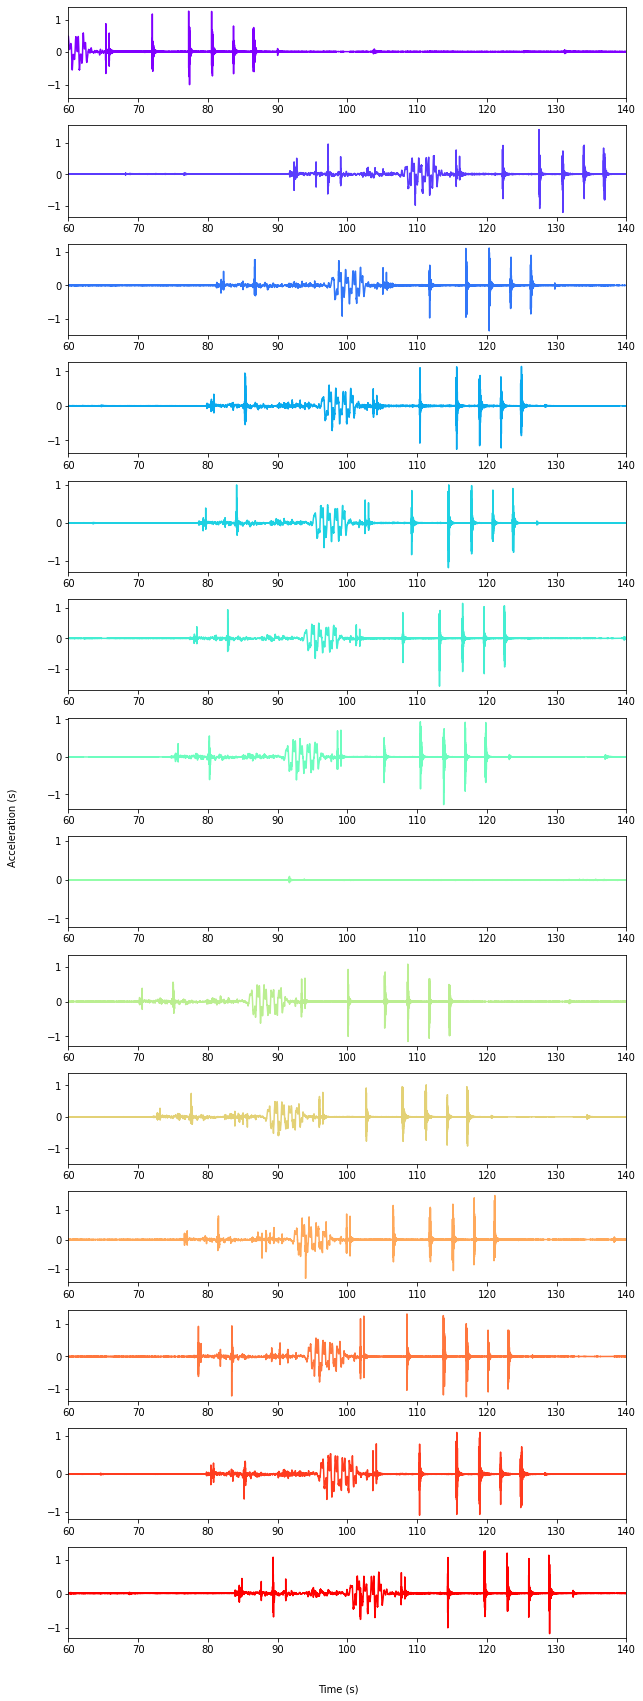

In [ ]:
if analysis_type == 2:
    master_table = analysis2(dir)
    print("Plotting comparison chart of sensors:")        
    compare_ax_chans(master_table)

Output of the Master Table is provided below:

In [ ]:
if analysis_type == 2:
  print(master_table.head(10))

       time       Ax0       Ax1  ...      Ax11      Ax12      Ax13
0  0.044342  0.018088  0.018715  ...  0.000019  0.005212  0.023650
1  0.048249  0.019004  0.016960  ... -0.000362  0.005746  0.026397
2  0.050202  0.020835  0.017265  ...  0.000629  0.006586  0.027770
3  0.052155  0.020530  0.017494  ...  0.003300  0.004297  0.028991
4  0.054108  0.019690  0.022682  ...  0.006199  0.006891  0.030059
5  0.056061  0.019614  0.025657  ...  0.005665  0.012079  0.029143
6  0.058014  0.020224  0.017952  ...  0.004444  0.012079  0.029906
7  0.059967  0.019614  0.015892  ...  0.005512  0.011240  0.031737
8  0.061920  0.018317  0.020088  ...  0.004826  0.013300  0.029677
9  0.063874  0.019461  0.018028  ...  0.001011  0.012994  0.028533

[10 rows x 15 columns]


When completing a multiple sensor analysis output the time lags.

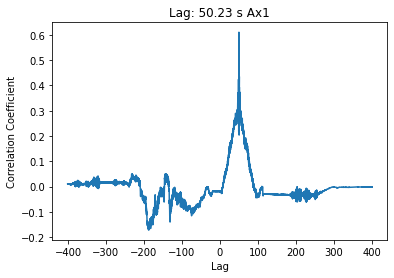

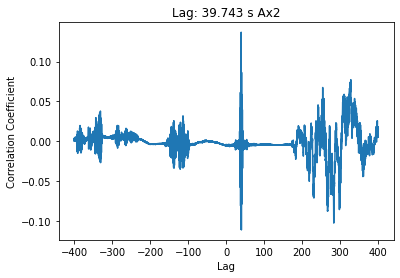

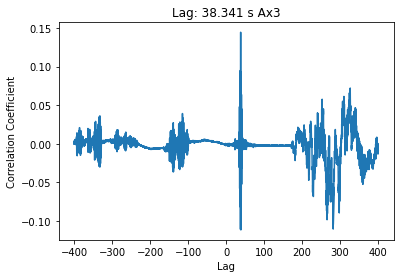

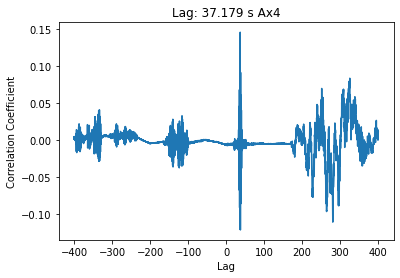

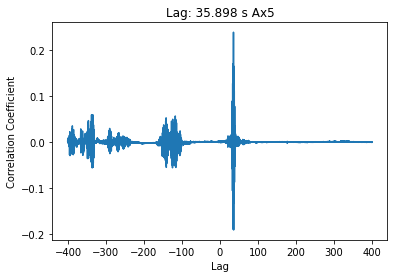

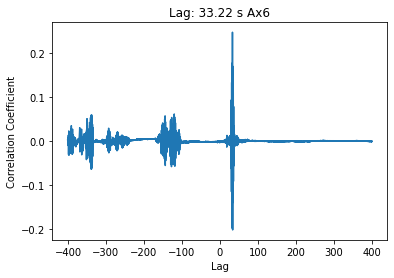

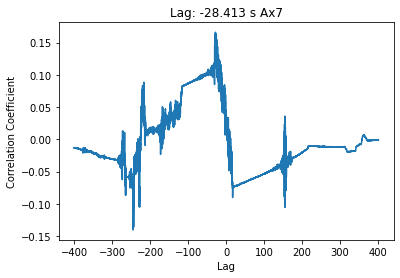

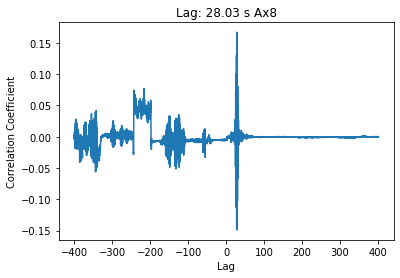

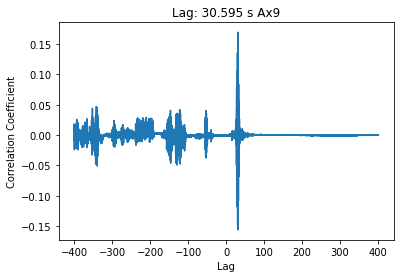

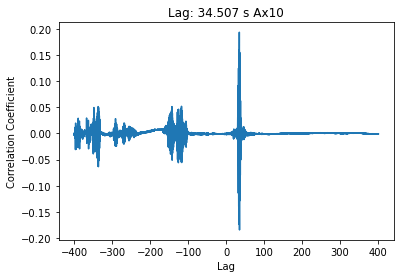

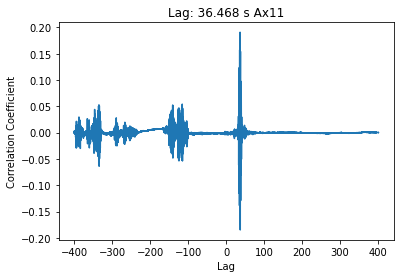

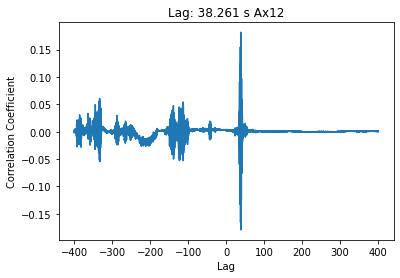

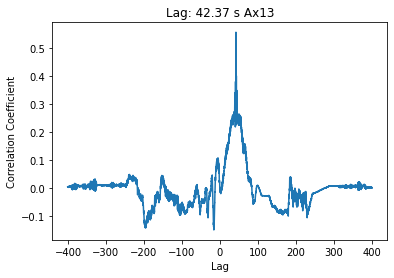

For the following file list:
['12.CSV', '152.CSV', '153.CSV', '164.CSV', '165.CSV', '167.CSV', '168.CSV', '171.CSV', '172.CSV', '174.CSV', '175.CSV', '178.CSV', '25.CSV']
The time delays are
[50.229614579348436, 39.743260902804366, 38.34091373577911, 37.1788015291217, 35.89754840715989, 33.21980750745013, -28.41315517033422, 28.030341737552988, 30.59480111123571, 34.506920018689186, 36.46786229681362, 38.260835415656516, 42.370220428777884]
compared to:
105.CSV


In [ ]:
if analysis_type == 2:    
    lag = lag_table(master_table,512)
    print("For the following file list:")
    print(sorted(os.listdir(dir))[1:])
    print("The time delays are")
    print(lag)
    print("compared to:")
    print(sorted(os.listdir(dir))[0])

## Running Analysis 2 - Post Lag Adjustment:
After lags were calculated the sensor data was truncated. The visualisation below shows the synced data for the first .CSV file of each sensor.

A further time drift analysis will be required.

14 of 14 completed...
Plotting comparison chart of sensors:


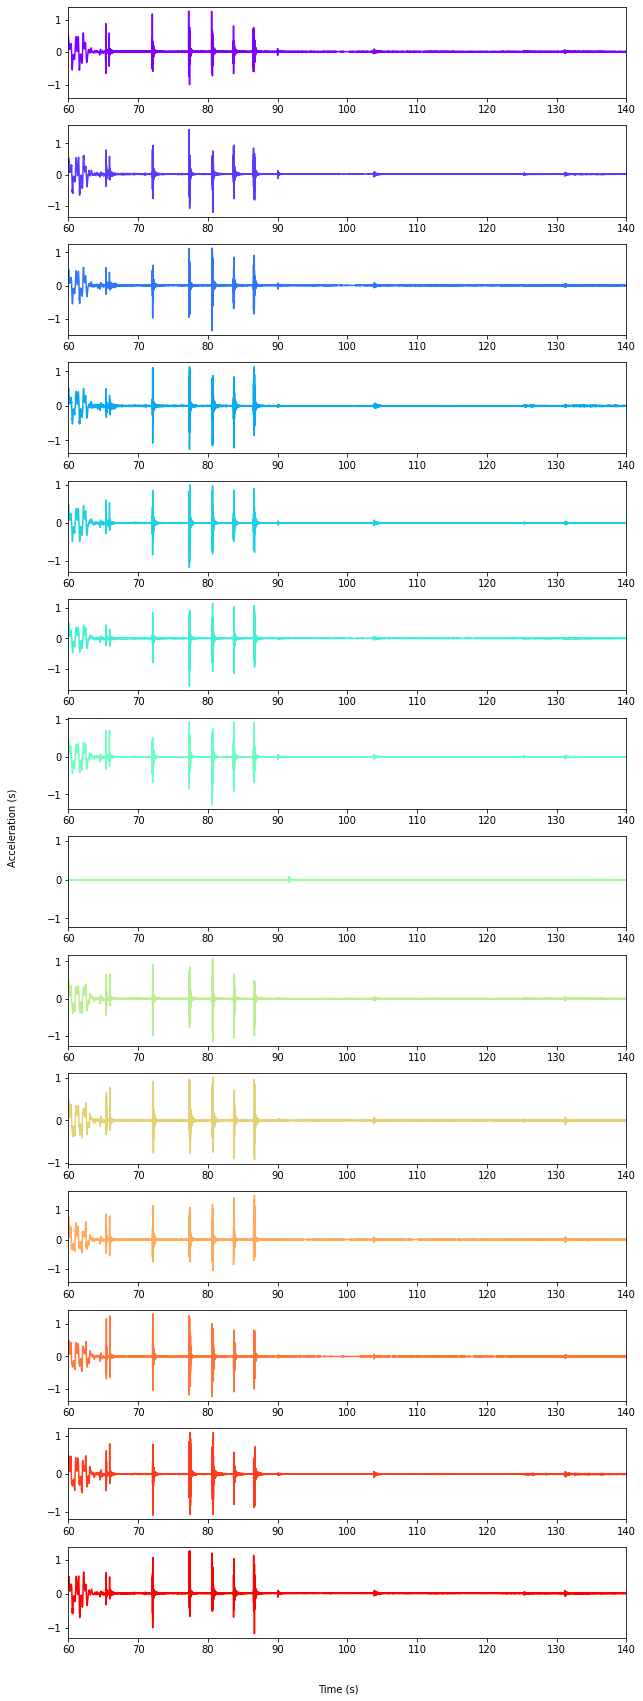

In [ ]:
if analysis_type == 2:
    master_table2 = analysis2(dir2)
    print("Plotting comparison chart of sensors:")        
    compare_ax_chans(master_table2)